# Final Report and Summary of Analysis: AI Scout for Improved Player Evaluation

#### CONTENTS

    I. Purpose
    II. Data
    III. Modeling
    IV. Conclusions
    V. Recommendations
    VI. Next Steps

In [110]:
# Imports
%load_ext autoreload
%autoreload 2

import os
import sys

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import itertools
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

from src import model_functions as mf
from src import data_cleaning as dc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## I. Purpose

Prior to last season the NBA launched the G-League to develop players coming out of high school that choose not to go to college. With this new opportunity to sign players out of high school, new development strategies are being implemented and knowing when to pull the plug on a player, and who to draft in order to fill out your roster. Using standard and advanced metrics, I’m creating an AI Scout for NBA general managers that predicts the probability of a prospect becoming a specific player type of the modern league given past performance and their physical characteristics. 

#### Goals:
- Use advanced metrics to better classify modern NBA player roles. 
- Using this new lens, develop a machine learning model to predict a young player's potential NBA classification or player role as they develop. 

With this tool, scouts and front office executives would have a better understanding of a young player's potential career trajectory, track that player's development progress year over year, and help make decisions on contract commitments.

## II. Data

Descriptions of the statistical categories used can be found in the `readme` file of the `data` folder. 

In order to classify modern nba players, this project uses advanced metrics that take advantage of player tracking and play-by-play data that isn’t available in traditional box scores.

- NBA Advanced Metrics from FiveThirtyEight Sports [`repository link`](https://github.com/fivethirtyeight/nba-player-advanced-metrics)

We'll use historical college statistics of our newly classified modern nba players in order to create the prediction model. Cross Validation will be used to train and test the model. 

- NCAA College statistics are available from [basketball-reference.com](https://basketball-reference.com). The dataset used in this project was obtained through [barttorvik.com](https://barttorvik.com)

Each row of data in these datasets represents a single season for the given player.

### *This notebook uses the SQLite3 database created in the notebook 00_create_database. Please go to the `/exploratory` folder of this repository and run those commands in order to reproduce this work.*

#### Import Data

In [15]:
import sqlite3

pd.set_option('display.max_columns', 500)

conn = sqlite3.connect('../../notebooks/exploratory/AI_SCOUT.db')

In [118]:
mod_data = pd.read_sql(
    """
    SELECT * FROM RAPTOR
    WHERE year_id BETWEEN 2008 AND 2020
    AND G >= 35
    """, conn)
mod_data.head()

,player_id,name_common,year_id,age,pos,team_id,tmRtg,franch_id,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr
0,youngtr01,Trae Young,2020,21,PG,ATL,-7.6,ATL,60,2120,65.1,35.3,29.3,59.5,9.2,4.2,1.2,4.8,7.1,-3.5,3.6,7.0,17.0,15.4,34.9,45.6,16.2,1.6,11.5,6.5,1.4,0.3,113.6,36.1,117.2,50.1,36.1,86.0,45.5,44.8
1,huntede01,De'Andre Hunter,2020,22,SF,ATL,-7.6,ATL,63,2018,62.0,32.0,13.5,52.1,1.9,5.0,1.1,1.8,-2.5,-1.3,-3.8,-1.1,5.9,4.7,17.5,8.0,12.1,2.3,13.1,7.6,1.0,0.7,99.5,16.9,117.3,45.4,35.5,76.4,44.5,21.1
2,huertke01,Kevin Huerter,2020,21,SG,ATL,-7.6,ATL,56,1760,54.1,31.4,13.6,53.6,4.2,4.5,1.5,1.7,-0.4,-2.4,-2.8,-0.1,8.0,8.1,17.1,17.5,12.0,2.1,12.0,7.0,1.4,1.3,107.1,17.2,116.5,45.3,38.0,82.8,54.8,10.5
3,reddica01,Cam Reddish,2020,20,SF,ATL,-7.6,ATL,58,1551,47.6,26.7,13.7,50.0,2.0,4.9,2.0,2.2,-2.8,-0.1,-3.0,-0.2,5.9,5.0,18.9,8.0,13.6,2.4,12.7,7.5,1.9,1.5,94.7,18.3,115.0,42.8,33.2,80.2,45.1,22.7
4,collijo01,John Collins,2020,22,PF,ATL,-7.6,ATL,41,1363,41.9,33.2,22.7,65.9,1.5,10.7,2.5,1.9,0.0,-0.3,-0.3,1.7,15.6,17.1,22.7,7.6,10.1,9.0,24.0,16.4,1.1,4.1,123.7,21.6,112.2,64.2,40.1,80.0,24.3,24.8


In [17]:
old_data = pd.read_sql(
    """
    SELECT * FROM RAPTOR
    WHERE year_id BETWEEN 1990 AND 2000
    AND G > 35;
    """, conn)
old_data.head()

,player_id,name_common,year_id,age,pos,team_id,tmRtg,franch_id,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr
0,mutomdi01,Dikembe Mutombo,2000,33,C,ATL,-5.8,ATL,82,2984,75.2,36.4,12.4,62.1,1.4,15.2,3.9,2.3,0.1,1.2,1.3,6.2,14.9,17.3,13.8,5.4,18.7,11.2,31.3,21.2,0.5,5.9,116.1,14.9,100.7,56.2,NaN,70.8,0.0,73.5
1,hendeal01,Alan Henderson,2000,27,PF,ATL,-5.8,ATL,82,2775,70.0,33.8,15.3,50.3,1.1,8.1,1.9,2.0,-0.7,-0.5,-1.2,2.3,8.2,9.4,19.4,4.6,11.4,10.5,12.1,11.3,1.5,1.3,104.5,19.3,108.5,46.5,10.0,67.1,1.1,35.9
2,jacksji01,Jim Jackson,2000,29,SF,ATL,-5.8,ATL,79,2767,69.8,35.0,18.7,49.6,3.3,5.6,1.0,2.6,0.2,-1.7,-1.5,1.8,9.6,7.8,24.2,14.5,12.2,4.0,11.6,7.8,1.1,0.2,101.1,23.3,110.4,41.8,38.6,87.7,24.5,17.2
3,rideris01,Isaiah Rider,2000,28,SG,ATL,-5.8,ATL,60,2084,52.5,34.7,21.8,48.8,4.1,4.9,0.9,3.2,0.2,-2.5,-2.3,0.5,10.0,6.7,28.8,19.4,12.4,3.3,10.2,6.8,1.0,0.2,99.2,27.7,111.0,44.1,31.1,78.5,16.8,24.3
4,colesbi01,Bimbo Coles,2000,31,PG,ATL,-5.8,ATL,80,1924,48.5,24.1,13.2,49.4,5.9,3.5,1.4,2.1,-0.1,-1.5,-1.6,1.1,8.5,7.1,17.4,24.6,13.6,1.7,8.1,4.9,1.6,0.4,104.4,17.9,110.3,47.2,20.5,81.7,6.4,17.1


In [176]:
ncaa_data = pd.read_sql(
    """
    SELECT * FROM NCAA
    """, conn)
ncaa_data.head()

,player_name,team,conf,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,class,ht,porpag,adjoe,pfr,year,pid,ast/tov,pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,3PAr
0,Charles Jenkins,Hofstra,CAA,29,82.3,99.6,24.5,50.0,54.72,5.4,9.7,13.7,23.0,96,123,0.780,140,279,0.502,20,61,0.328,1.6,2.9,36.2,Fr,6-3,2.46278,105.611,3.1,2008,57,0.618572,44.0,100.4870,102.2670,2.89215,182.051,1.37808,0.690653,0.687429,1.72087,34.6207,1.14810,0.572774,1.5862,3.0000,4.5862,2.0690,1.6897,0.5172,15.0345,0.179412
1,Charles Jenkins,Hofstra,CAA,31,86.2,104.3,30.8,43.1,50.76,2.7,11.9,32.6,18.5,183,223,0.821,166,396,0.419,30,94,0.319,1.4,2.4,45.5,So,6-3,4.02167,117.884,3.1,2009,57,1.276195,44.0,97.5891,98.6127,3.30834,199.390,3.42258,2.775530,0.647047,4.61490,35.0323,3.44840,1.166500,0.9032,3.8387,4.7419,4.3226,1.4194,0.4516,19.5161,0.191837
2,Charles Jenkins,Hofstra,CAA,33,91.5,109.4,28.1,49.8,55.28,3.2,10.1,24.9,17.7,167,208,0.803,170,375,0.453,62,153,0.405,1.5,2.8,39.4,Jr,6-3,4.69062,121.454,2.9,2010,57,1.247627,44.0,98.4249,97.5968,3.66979,216.649,4.67981,4.352100,0.327710,7.51246,37.0000,5.93298,1.579480,1.1515,3.4545,4.6061,3.9697,1.8182,0.5455,21.0000,0.289773
3,Charles Jenkins,Hofstra,CAA,32,92.4,123.2,28.7,57.7,62.93,1.6,8.6,31.3,12.8,179,217,0.825,176,317,0.555,63,152,0.414,1.8,2.7,46.3,Sr,6-3,6.65016,136.761,2.1,2011,57,2.112628,44.0,107.8070,106.3460,2.64050,192.184,7.09443,8.324560,-1.230130,9.82813,37.4062,8.91582,0.912311,0.5000,2.7188,3.2188,4.6875,1.6562,0.6250,22.5000,0.324094
4,Richard Hendrix,Alabama,SEC,32,73.1,117.4,26.2,60.1,59.36,13.1,23.5,11.5,12.3,108,201,0.537,227,376,0.604,2,7,0.286,7.2,2.4,52.5,Jr,6-9,4.77910,130.431,3.8,2008,65,0.927275,49.0,96.4548,91.9969,3.63708,236.544,9.73426,5.204960,4.529300,8.86131,30.6250,6.61813,2.243180,3.6875,6.4062,10.0938,1.5938,1.2812,1.9688,17.7500,0.018277


#### Data Cleaning

In [22]:
old_df = dc.clean_old_df(old_data, None)
old_df.head()

,age,pos,tmRtg,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr
1,27,PF,-5.8,82,2775,70.0,33.8,15.3,50.3,1.1,8.1,1.9,2.0,-0.7,-0.5,-1.2,2.3,8.2,9.4,19.4,4.6,11.4,10.5,12.1,11.3,1.5,1.3,104.5,19.3,108.5,46.5,10.0,67.1,1.1,35.9
2,29,SF,-5.8,79,2767,69.8,35.0,18.7,49.6,3.3,5.6,1.0,2.6,0.2,-1.7,-1.5,1.8,9.6,7.8,24.2,14.5,12.2,4.0,11.6,7.8,1.1,0.2,101.1,23.3,110.4,41.8,38.6,87.7,24.5,17.2
3,28,SG,-5.8,60,2084,52.5,34.7,21.8,48.8,4.1,4.9,0.9,3.2,0.2,-2.5,-2.3,0.5,10.0,6.7,28.8,19.4,12.4,3.3,10.2,6.8,1.0,0.2,99.2,27.7,111.0,44.1,31.1,78.5,16.8,24.3
4,31,PG,-5.8,80,1924,48.5,24.1,13.2,49.4,5.9,3.5,1.4,2.1,-0.1,-1.5,-1.6,1.1,8.5,7.1,17.4,24.6,13.6,1.7,8.1,4.9,1.6,0.4,104.4,17.9,110.3,47.2,20.5,81.7,6.4,17.1
5,22,PG,-5.8,81,1888,47.6,23.3,13.7,49.7,7.2,3.4,2.1,3.2,0.4,-0.7,-0.3,2.4,9.7,8.6,19.2,29.3,19.1,1.4,8.2,4.8,2.5,0.3,99.6,20.2,108.4,45.8,29.3,80.7,26.2,23.3


In [38]:
mod_df = dc.clean_new_df(mod_data, None)
mod_df.head()

,age,pos,tmRtg,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr
0,21,PG,-7.6,60,2120,65.1,35.3,29.3,59.5,9.2,4.2,1.2,4.8,7.1,-3.5,3.6,7.0,17.0,15.4,34.9,45.6,16.2,1.6,11.5,6.5,1.4,0.3,113.6,36.1,117.2,50.1,36.1,86.0,45.5,44.8
1,22,SF,-7.6,63,2018,62.0,32.0,13.5,52.1,1.9,5.0,1.1,1.8,-2.5,-1.3,-3.8,-1.1,5.9,4.7,17.5,8.0,12.1,2.3,13.1,7.6,1.0,0.7,99.5,16.9,117.3,45.4,35.5,76.4,44.5,21.1
2,21,SG,-7.6,56,1760,54.1,31.4,13.6,53.6,4.2,4.5,1.5,1.7,-0.4,-2.4,-2.8,-0.1,8.0,8.1,17.1,17.5,12.0,2.1,12.0,7.0,1.4,1.3,107.1,17.2,116.5,45.3,38.0,82.8,54.8,10.5
3,20,SF,-7.6,58,1551,47.6,26.7,13.7,50.0,2.0,4.9,2.0,2.2,-2.8,-0.1,-3.0,-0.2,5.9,5.0,18.9,8.0,13.6,2.4,12.7,7.5,1.9,1.5,94.7,18.3,115.0,42.8,33.2,80.2,45.1,22.7
4,22,PF,-7.6,41,1363,41.9,33.2,22.7,65.9,1.5,10.7,2.5,1.9,0.0,-0.3,-0.3,1.7,15.6,17.1,22.7,7.6,10.1,9.0,24.0,16.4,1.1,4.1,123.7,21.6,112.2,64.2,40.1,80.0,24.3,24.8


## III. Model Creation

    1. Positionality Exploration Across Eras
        a. Build
        b. Evaluate
    2. Cluster 
        a. Scale
        b. Dimensionality Reduction
            i. PCA
            ii. LDA
        c. Feature Consolidation
        d. Build
        e. Evaluate
    3. Label Identification and Understanding
    4. Prediction Model
        a. Prepare NCAA dataset with target labels
        a. Build
        b. Evaluate

### 1. Positionality Exploration Across Eras

- ##### 1a. Build

In [23]:
# 90's ERA
# Define X and y
X = old_df.drop(columns=['pos'], axis = 1)
y = old_df['pos']

In [57]:
model, X_test, y_test, y_hat_test, y_hat_proba = mf.lrm(X, y, 23)

In [39]:
# MODERN ERA
# Define X and y
X2 = mod_df.drop(columns = ['pos'], axis = 1)
y2 = mod_df['pos']

In [58]:
model2, X2_test, y2_test, y2_hat_test, y2_hat_proba = mf.lrm(X2, y2, 23)

- ##### 1b. Evaluate

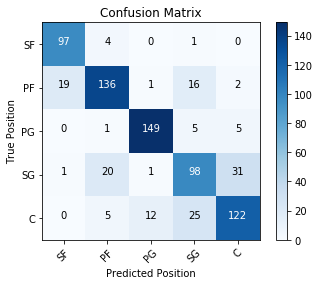

 recall:  0.8113497298200217 
 precision:  0.8001618871813868


In [73]:
# 90's ERA
cnf_matrix = confusion_matrix(y_test, y_hat_test)
recall, precision = mf.show_cm(cnf_matrix, y)

In [70]:
# 90's ERA Cross Validation
predicted = cross_val_predict(model, X, y, cv=10)
print (metrics.classification_report(y, predicted))

              precision    recall  f1-score   support

           C       0.82      0.87      0.85       450
          PF       0.77      0.76      0.77       632
          PG       0.88      0.89      0.88       662
          SF       0.69      0.61      0.65       637
          SG       0.65      0.71      0.68       622

    accuracy                           0.76      3003
   macro avg       0.76      0.77      0.77      3003
weighted avg       0.76      0.76      0.76      3003



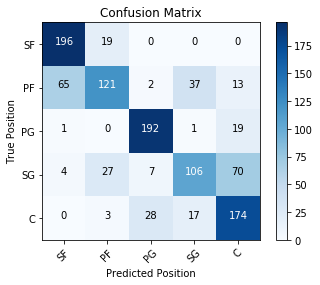

 recall:  0.720110121122606 
 precision:  0.7151709269040324


In [49]:
# MODERN ERA
cnf_matrix2 = confusion_matrix(y2_test, y2_hat_test)
recall2, precision2 = mf.show_cm(cnf_matrix2, y2)

In [71]:
# MODERN ERA Cross Validation
predicted2 = cross_val_predict(model2, X2, y2, cv=10)
print (metrics.classification_report(y2, predicted2))

              precision    recall  f1-score   support

           C       0.76      0.86      0.81       858
          PF       0.65      0.53      0.58       890
          PG       0.82      0.89      0.86       861
          SF       0.58      0.48      0.53       827
          SG       0.65      0.71      0.67       972

    accuracy                           0.70      4408
   macro avg       0.69      0.70      0.69      4408
weighted avg       0.69      0.70      0.69      4408



The takeaway here is that positional labels have become more fluid in the modern era as shown by the decrease in scores by 6-7% on average. The PF position in particular showed a drop of nearly 20% in F1-score. The model shows that statistically there are more that can be comparable to shooting gaurds, small forwards, and centers. 

### 2. Cluster Modeling

In [74]:
from src import cluster_functions as cf

In [90]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X2)

- ##### Dimensionality Reduction

In [91]:
pca = PCA(n_components=2)
pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)
print("Cumulative Explained Variance:", pca.explained_variance_ratio_.sum())

Cumulative Explained Variance: 0.4965935393930007


In [92]:
LDA = LinearDiscriminantAnalysis(n_components=2, 
                                 shrinkage='auto', 
                                 solver='eigen')

In [95]:
LDA_reduced_df = LDA.fit(X_scaled,y2).transform(X_scaled)
LDA.score(X_scaled,y2)

0.7044010889292196

The LDA explaind variance at 70% is initially much higher than a 2 component PCA reduction. Lets see how well the clusters can differentiate.

2 0.5006799491942199
3 0.5118463338901772
4 0.43165904430868296
5 0.38570952405595477
6 0.36671789329902227
7 0.34716711035128217
8 0.3242681556355149
9 0.331994568767971
10 0.33621307196235617
11 0.33407270891246454
12 0.32139548670056517
13 0.32774394882115526
14 0.3268978287724816
15 0.3270515857799974
16 0.32595573295798086
17 0.3260928931226231
18 0.32408227119293337
19 0.32232772891342276


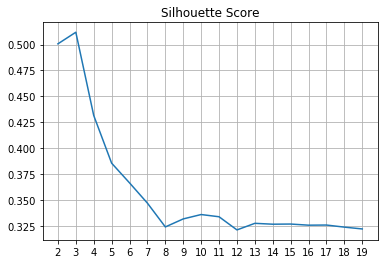

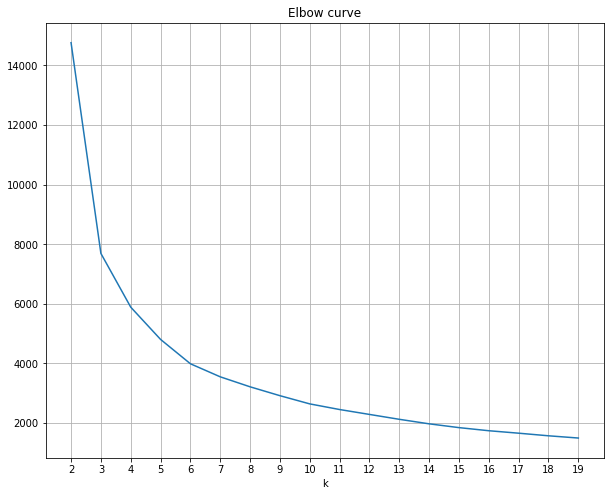

In [96]:
cf.find_best_cluster(LDA_reduced_df,2,20)

There doesn't seem to be definitive elbow, and the best bump in silouette score visually comes at 9 components, although the increase is small. 

In [100]:
k_means = cf.kmeans(LDA_reduced_df, 9)

In [101]:
# Assign labels
# data['Cluster'] = k_means['labels']
# mod_data['Cluster'] = cf.k_means['labels']

# Print silhouette score
print ("silhouette score:", k_means['silhouette_score'])

silhouette score: 0.331994568767971


Lets use cross validation to see if there is a definitive number of components in pca to use

Best parameter (CV score=0.922):
{'logistic__C': 21.54434690031882, 'pca__n_components': 38}


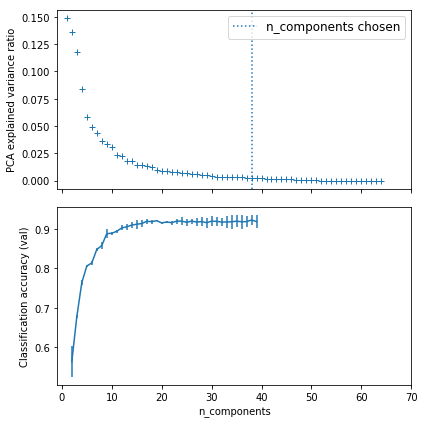

In [99]:
mf.dim_red(X_scaled, y2, 23)

38 components does not reduce our dimensionality. Lets look into the features and see if we can eliminate redundant columns.

- ##### Feature Consolidation

In [103]:
X_new = mod_df[['Raptor+/-', 'Raptor D','Raptor O','TS%','PIE%','ORtg','%Pos','3P%', '3PAr', 'FTAr', 'AST%', 'USG%', '2P%']]
y_new = mod_df['pos']

In [104]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X_new)

In [158]:
pca = PCA(n_components=3)
pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)
print("Cumulative Explained Variance:", pca.explained_variance_ratio_.sum())

Cumulative Explained Variance: 0.7394563595569947


In [106]:
LDA_reduced_df = LDA.fit(X_scaled,y_new).transform(X_scaled)
LDA.score(X_scaled,y_new)

0.6320326678765881

2 0.26712323766075197
3 0.2914239434035136
4 0.28249027697271883
5 0.26821722502739703
6 0.27750740005767505
7 0.26162187529753594
8 0.25347327454756063
9 0.2496601629806081
10 0.2475605199947332
11 0.24770677843324393
12 0.24947139590626294
13 0.24671158929723302
14 0.24203722306259232
15 0.24484483802997314
16 0.2435910436243844
17 0.24199874069744925
18 0.24165459979389992
19 0.23771664577106774


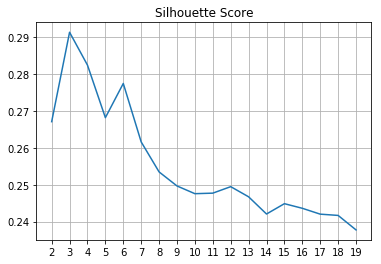

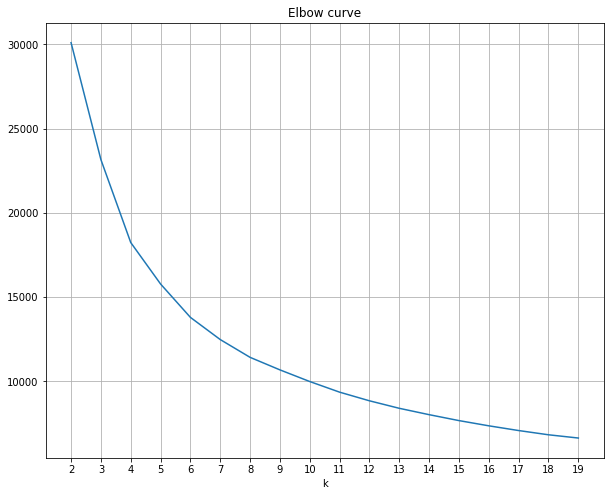

In [108]:
cf.find_best_cluster(X_pca,2,20)

While the elbow at 6 components is slight, there is a clear peak in silouette score. Lets build a Gaussian Mixture Model using 6 clusters. 

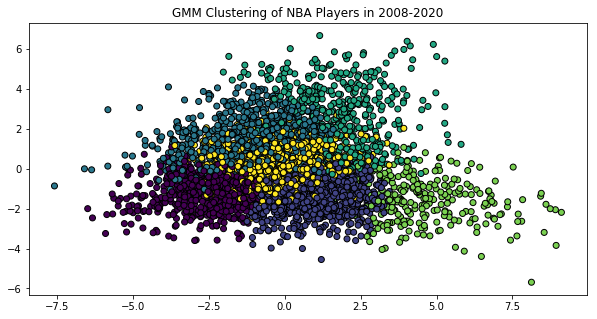

In [119]:
from sklearn.mixture import GaussianMixture
from matplotlib.ticker import MaxNLocator
fig = plt.figure(figsize = (10, 5))
gmm = GaussianMixture(n_components=6).fit(X_pca)
labels = gmm.predict(X_pca)
mod_data['gmm_cluster'] = labels
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', edgecolor='black')
plot_title="GMM Clustering of NBA Players in 2008-2020"
plt.title(plot_title);

The graph above shows two of the three principle components due to the 2 dimensional space we are viewing them. The three components comprise 74% of the total variation. The overlapping clusters illustrate that whatever sets those clusters apart isn’t a part of the two principal components used as the axes for the graph. In order to understand what sets the clusters apart we'll need to look into the players and feature importance within each cluster. 

In [121]:
#Find the probability of each row belonging to a cluster
probs = np.round(gmm.predict_proba(X_pca)*100, 4)
# mod_data['prob'] = probs
print(labels,probs)

[4 0 5 ... 0 2 0] [[0.00000e+00 7.75000e-02 0.00000e+00 2.80000e-03 9.99197e+01 0.00000e+00]
 [6.08811e+01 6.60310e+00 4.80000e-03 1.29600e-01 5.58000e-02 3.23256e+01]
 [3.41265e+01 1.21962e+01 0.00000e+00 3.23000e-02 4.60000e-02 5.35989e+01]
 ...
 [7.34480e+01 1.86739e+01 5.67300e-01 4.88100e-01 4.61000e-01 6.36180e+00]
 [1.34089e+01 7.10000e-03 8.62491e+01 1.13700e-01 4.52000e-02 1.76000e-01]
 [9.56021e+01 1.96970e+00 1.05600e-01 5.65000e-02 3.20000e-02 2.23410e+00]]


In [122]:
prob_df = pd.DataFrame(data=probs, columns=["c0","c1","c2","c3","c4","c5"])
prob_df.head()

,c0,c1,c2,c3,c4,c5
0,0.0000,0.0775,0.0000,0.0028,99.9197,0.0000
1,60.8811,6.6031,0.0048,0.1296,0.0558,32.3256
2,34.1265,12.1962,0.0000,0.0323,0.0460,53.5989
3,74.3223,7.2928,0.0292,0.1560,0.0819,18.1179
4,1.0540,11.1951,0.5975,45.5912,14.0604,27.5018


In [130]:
gmm_df=pd.concat([mod_data, prob_df], axis=1)
gmm_df.head()

,player_id,name_common,year_id,age,pos,team_id,tmRtg,franch_id,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr,gmm_cluster,c0,c1,c2,c3,c4,c5
0,youngtr01,Trae Young,2020,21,PG,ATL,-7.6,ATL,60,2120,65.1,35.3,29.3,59.5,9.2,4.2,1.2,4.8,7.1,-3.5,3.6,7.0,17.0,15.4,34.9,45.6,16.2,1.6,11.5,6.5,1.4,0.3,113.6,36.1,117.2,50.1,36.1,86.0,45.5,44.8,4,0.0000,0.0775,0.0000,0.0028,99.9197,0.0000
1,huntede01,De'Andre Hunter,2020,22,SF,ATL,-7.6,ATL,63,2018,62.0,32.0,13.5,52.1,1.9,5.0,1.1,1.8,-2.5,-1.3,-3.8,-1.1,5.9,4.7,17.5,8.0,12.1,2.3,13.1,7.6,1.0,0.7,99.5,16.9,117.3,45.4,35.5,76.4,44.5,21.1,0,60.8811,6.6031,0.0048,0.1296,0.0558,32.3256
2,huertke01,Kevin Huerter,2020,21,SG,ATL,-7.6,ATL,56,1760,54.1,31.4,13.6,53.6,4.2,4.5,1.5,1.7,-0.4,-2.4,-2.8,-0.1,8.0,8.1,17.1,17.5,12.0,2.1,12.0,7.0,1.4,1.3,107.1,17.2,116.5,45.3,38.0,82.8,54.8,10.5,5,34.1265,12.1962,0.0000,0.0323,0.0460,53.5989
3,reddica01,Cam Reddish,2020,20,SF,ATL,-7.6,ATL,58,1551,47.6,26.7,13.7,50.0,2.0,4.9,2.0,2.2,-2.8,-0.1,-3.0,-0.2,5.9,5.0,18.9,8.0,13.6,2.4,12.7,7.5,1.9,1.5,94.7,18.3,115.0,42.8,33.2,80.2,45.1,22.7,0,74.3223,7.2928,0.0292,0.1560,0.0819,18.1179
4,collijo01,John Collins,2020,22,PF,ATL,-7.6,ATL,41,1363,41.9,33.2,22.7,65.9,1.5,10.7,2.5,1.9,0.0,-0.3,-0.3,1.7,15.6,17.1,22.7,7.6,10.1,9.0,24.0,16.4,1.1,4.1,123.7,21.6,112.2,64.2,40.1,80.0,24.3,24.8,3,1.0540,11.1951,0.5975,45.5912,14.0604,27.5018


Save the new table to the AI_SCOUT database. Note the labels you generate when running this notebook may not match the order of mine but the cluster groups will contain the same players. I've commented out the code line below for consistency in explaining my results. Just uncomment and run the cell if this is your first time running through the notebook.

In [891]:
# Save Table to AI_SCOUT.db
# gmm_df.to_sql('CLUSTERS_4', conn, if_exists='replace', index=False)

### 3. Label Identification and Understanding

*C0*:
Two-way long distance shooters, generally not the first scoring option, but accurate from deep.
- Ray Allen
- Danny Green
- JJ Redick
- Kyle Korver

In [132]:
C0_data = pd.read_sql(
    """
    SELECT * FROM CLUSTERS_4
    WHERE gmm_cluster=0
    ORDER BY "c0" DESC
    """, conn)

      Feature  Importance  Cluster Average  League Average
0        PIE%    0.452534         8.200863        9.413770
1    Raptor O    0.416377        -0.217647       -0.437636
2         TS%    0.350064        55.521412       53.956942
3        ORtg    0.343079       110.231137      107.406624
4        %Pos    0.330918        15.786118       19.028335
5   Raptor+/-    0.315331        -0.233725       -0.499660
6        USG%    0.314517        16.087765       19.035345
7         3P%    0.156274        37.476471       28.084959
8        AST%    0.141299        10.448314       13.661025
9         2P%    0.128481        49.714353       48.971892
10       FTAr    0.089716        20.618667       27.541833
11   Raptor D    0.023133        -0.016078       -0.062228
12       3PAr   -0.065236        44.495373       27.469964


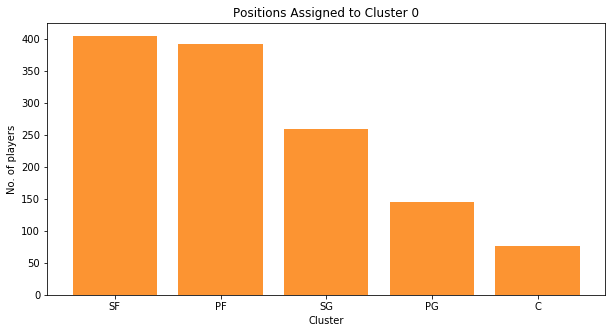

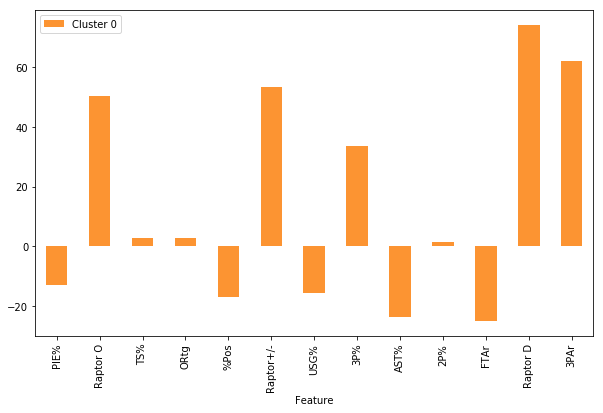

In [167]:

fi0 = cf.feature_importance(C0_data, mod_df, 3).reset_index().drop('index', axis=1)
print(fi0)
fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 
plt.bar(C0_data['pos'].unique(), C0_data['pos'].value_counts(), color ='#fc9432') 
plt.xlabel("Cluster") 
plt.ylabel("No. of players") 
plt.title("Positions Assigned to Cluster 0") 
plt.show() 

cf.bar_features(fi0, 'Cluster 0', '#fc9432')


----------------------

*C1*:
Perimeter role player, 3pt spot up shooters, defensive liability

      Feature  Importance  Cluster Average  League Average
0        3PAr    0.084165        35.498839       27.469964
1    Raptor D    0.056912        -1.043541       -0.062228
2        AST%   -0.080309        13.303193       13.661025
3        FTAr   -0.110280        19.551524       27.541833
4         3P%   -0.163236        32.061538       28.084959
5   Raptor+/-   -0.191558        -3.520610       -0.499660
6         2P%   -0.242032        42.722642       48.971892
7        %Pos   -0.274937        17.900145       19.028335
8        USG%   -0.278179        18.017417       19.035345
9    Raptor O   -0.375017        -2.476923       -0.437636
10       ORtg   -0.405196        96.152830      107.406624
11        TS%   -0.428133        47.824093       53.956942
12       PIE%   -0.456128         6.211756        9.413770


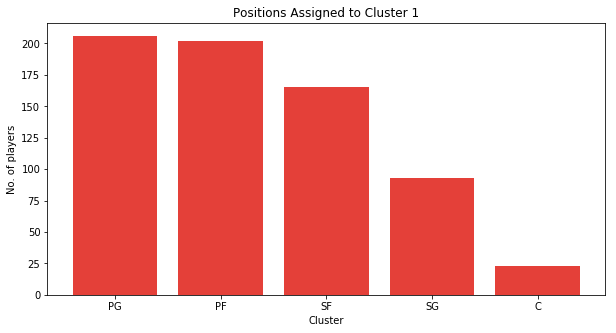

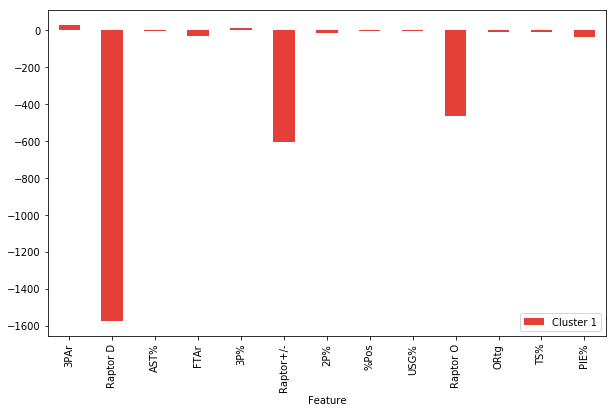

In [149]:
C1_data = pd.read_sql(
    """
    SELECT * FROM CLUSTERS_4
    WHERE gmm_cluster=1
    """, conn)
fi1 = cf.feature_importance(C1_data, mod_df, 3).reset_index().drop('index', axis=1)
print(fi1)
fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 

plt.bar(C1_data['pos'].unique(), C1_data['pos'].value_counts(), color ='#e44039') 
  
plt.xlabel("Cluster") 
plt.ylabel("No. of players") 
plt.title("Positions Assigned to Cluster 1") 
plt.show() 
cf.bar_features(fi1, 'Cluster 1', '#e44039')

------------

*C2*:
Close to the rim, defensive minded bigs. No outside shot, but can get to the free throw line. C5 Backup.
- Kendrick Perkins
- Ben Wallace

      Feature  Importance  Cluster Average  League Average
0        3PAr    0.080562         2.137113       27.469964
1        FTAr    0.013932        34.812371       27.541833
2         3P%   -0.007628         5.390427       28.084959
3    Raptor D   -0.058787         0.143741       -0.062228
4        AST%   -0.144464         7.462297       13.661025
5        USG%   -0.239516        17.175110       19.035345
6        %Pos   -0.248719        17.539175       19.028335
7   Raptor+/-   -0.310074        -2.430339       -0.499660
8         2P%   -0.331678        49.002209       48.971892
9         TS%   -0.386404        51.866863       53.956942
10       ORtg   -0.387256       104.059499      107.406624
11   Raptor O   -0.403607        -2.575405       -0.437636
12       PIE%   -0.425879         8.359941        9.413770


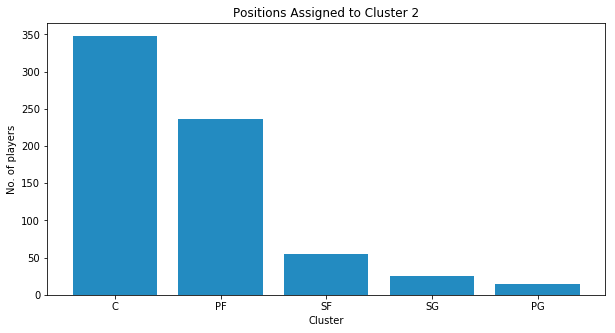

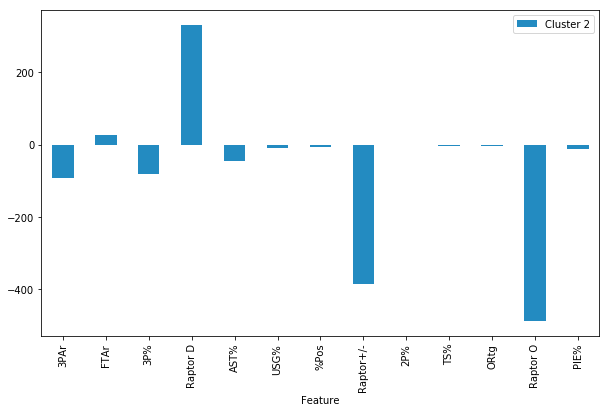

In [152]:
C2_data = pd.read_sql(
    """
    SELECT * FROM CLUSTERS_4
    WHERE gmm_cluster=2
    """, conn)
fi2 = cf.feature_importance(C2_data, mod_df, 3).reset_index().drop('index', axis=1)
print(fi2)
fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 

plt.bar(C2_data['pos'].unique(), C2_data['pos'].value_counts(), color ='#238bc1') 
  
plt.xlabel("Cluster") 
plt.ylabel("No. of players") 
plt.title("Positions Assigned to Cluster 2") 
plt.show() 
cf.bar_features(fi2, 'Cluster 2', '#238bc1')

---------------

*C3*:
Versatile sharp-shooters, generally a higher % of shots come from long-distance. C4 potential but can be lacking on defense. Can create offense for themselves and teammates. Poor man's C4. 
- Kyle Lowry
- Jamal Crawford
- Deron Williams
- Tony Parker

      Feature  Importance  Cluster Average  League Average
0        AST%    0.049512        20.644020       13.661025
1        %Pos   -0.008942        22.944020       19.028335
2        USG%   -0.028385        23.023719       19.035345
3        3PAr   -0.070907        29.981508       27.469964
4    Raptor D   -0.110149        -0.481809       -0.062228
5        FTAr   -0.141207        26.135678       27.541833
6         3P%   -0.216407        35.180201       28.084959
7         2P%   -0.278449        47.297789       48.971892
8        PIE%   -0.341994        10.896281        9.413770
9   Raptor+/-   -0.367393         0.305025       -0.499660
10   Raptor O   -0.402516         0.786533       -0.437636
11        TS%   -0.447984        53.511457       53.956942
12       ORtg   -0.469629       106.674673      107.406624


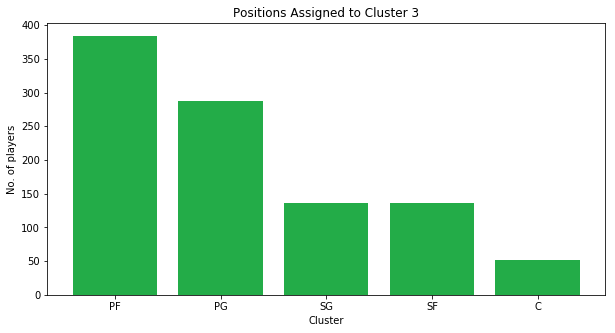

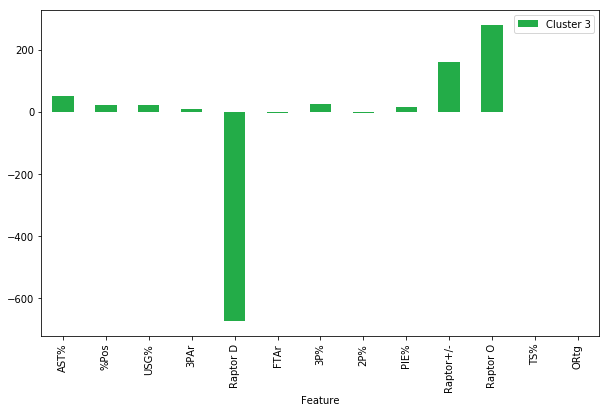

In [154]:
C3_data = pd.read_sql(
    """
    SELECT * FROM CLUSTERS_4
    WHERE gmm_cluster=3
    """, conn)
fi3 = cf.feature_importance(C3_data, mod_df,3).reset_index().drop('index', axis=1)
print(fi3)
fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 

plt.bar(C3_data['pos'].unique(), C3_data['pos'].value_counts(), color ='#23ac48') 
  
plt.xlabel("Cluster") 
plt.ylabel("No. of players") 
plt.title("Positions Assigned to Cluster 3") 
plt.show() 

cf.bar_features(fi3, 'Cluster 3', '#23ac48')

---------------

*C4*:
No weakness, 2-way players, create offense for themselves and teammates. 1st option, max contract players. 
Build your team around superstars
- Steph Curry
- Lebron
- Nikola Jokic
- Kevin Durant

      Feature  Importance  Cluster Average  League Average
0    Raptor O    0.417849         4.279643       -0.437636
1        ORtg    0.405627       114.889643      107.406624
2         TS%    0.401606        57.958214       53.956942
3   Raptor+/-    0.394562         4.742857       -0.499660
4        PIE%    0.304490        16.210000        9.413770
5        3PAr    0.279610        24.407857       27.469964
6         2P%    0.268415        51.351071       48.971892
7         3P%    0.268160        34.383571       28.084959
8        AST%    0.141893        28.515357       13.661025
9    Raptor D    0.082427         0.468571       -0.062228
10       %Pos    0.033534        28.680357       19.028335
11       FTAr    0.028450        37.537857       27.541833
12       USG%    0.013730        28.487143       19.035345


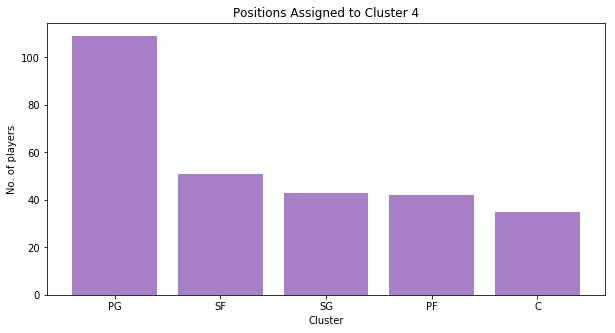

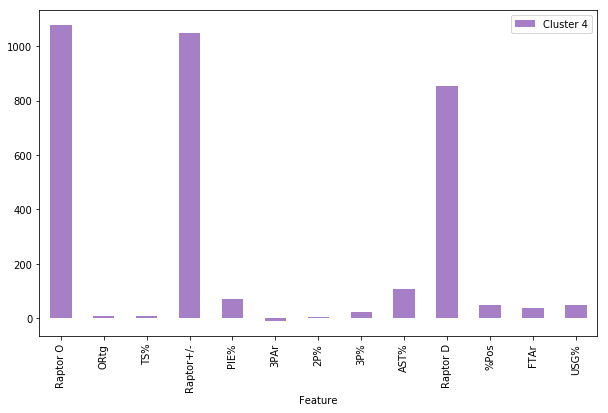

In [155]:
C4_data = pd.read_sql(
    """
    SELECT * FROM CLUSTERS_4
    WHERE gmm_cluster=4
    """, conn)

fi4 = cf.feature_importance(C4_data, mod_df, 3).reset_index().drop('index', axis=1)
print(fi4)
fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 

plt.bar(C4_data['pos'].unique(), C4_data['pos'].value_counts(), color ='#a77fc6') 
  
plt.xlabel("Cluster") 
plt.ylabel("No. of players") 
plt.title("Positions Assigned to Cluster 4") 
plt.show() 
cf.bar_features(fi4, 'Cluster 4', '#a77fc6')

------------

*C5*:
Traditional center mold, or PF without range, but a knack for scoring around the rim. They clean up rebounds and are likely the most impactful defender on your team. 
- Dwight Howard
- Rudy Gobert
- Tyson Chandler

      Feature  Importance  Cluster Average  League Average
0        %Pos    0.439810        17.647959       19.028335
1        USG%    0.431023        17.214286       19.035345
2        PIE%    0.373040        11.638571        9.413770
3        AST%    0.311006         8.445510       13.661025
4   Raptor+/-    0.293641         1.101837       -0.499660
5    Raptor O    0.292720        -0.361633       -0.437636
6    Raptor D    0.129444         1.460816       -0.062228
7         3P%    0.063547        11.497551       28.084959
8        3PAr   -0.000423         3.633469       27.469964
9        FTAr   -0.132815        43.860000       27.541833
10       ORtg   -0.207658       117.729796      107.406624
11        TS%   -0.235630        60.024082       53.956942
12        2P%   -0.275527        57.825102       48.971892


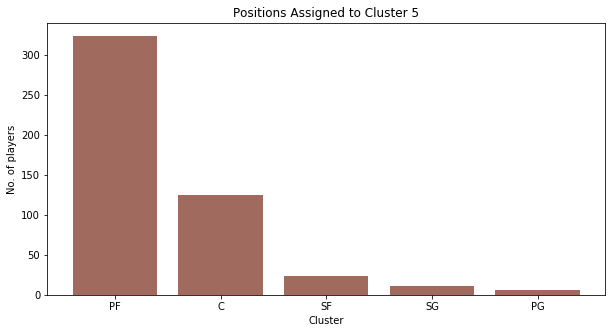

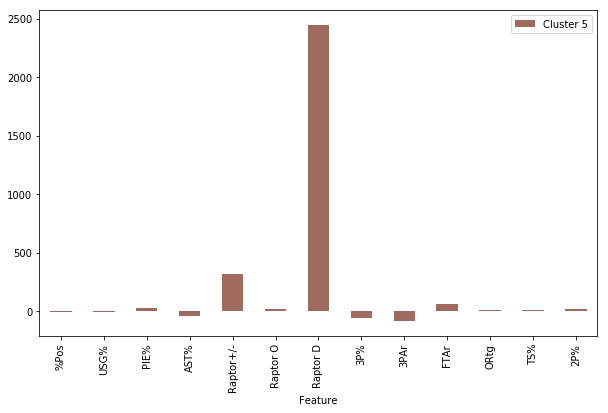

In [156]:
C5_data = pd.read_sql(
    """
    SELECT * FROM CLUSTERS_4
    WHERE gmm_cluster=5
    """, conn)
fi5=cf.feature_importance(C5_data, mod_df,3).reset_index().drop('index', axis=1)
print(fi5)
fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 

plt.bar(C5_data['pos'].unique(), C5_data['pos'].value_counts(), color ='#a06a5e') 
  
plt.xlabel("Cluster") 
plt.ylabel("No. of players") 
plt.title("Positions Assigned to Cluster 5") 
plt.show() 

cf.bar_features(fi5, 'Cluster 5', '#a06a5e')

Now that we have our labels lets add our labels to our table of historical NCAA Player Statistics

In [222]:
joined_df = pd.read_sql(
    """
    SELECT NCAA.*, nba.gmm_cluster
    FROM CLUSTERS_4 nba
    INNER JOIN NCAA ON
    NCAA.player_name = nba.name_common;
    """, conn)

In [225]:
group_df = dc.clean_labeled_df(joined_df)
group_df.head()

,player_name,team,conf,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,class_,ht,porpag,adjoe,pfr,year,pid,ast/tov,pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,3PAr,gmm_cluster
0,Stephen Curry,Davidson,SC,33,82.1,118.0,37.5,54.9,60.46,1.8,12.3,39.8,16.6,212,241,0.880,176,340,0.518,127,327,0.388,0.7,3.9,36.1,3,6-3,6.66086,141.028,2.8,2009,1827,1.431981,7.0,89.1128,88.3785,4.44618,253.620,12.3076,9.67838,2.62918,15.27900,33.8182,10.79090,4.48812,0.5758,3.9091,4.4848,5.4242,2.3333,0.2121,28.6364,0.490255,c4
2,Stephen Curry,Davidson,SC,33,82.1,118.0,37.5,54.9,60.46,1.8,12.3,39.8,16.6,212,241,0.880,176,340,0.518,127,327,0.388,0.7,3.9,36.1,3,6-3,6.66086,141.028,2.8,2009,1827,1.431981,7.0,89.1128,88.3785,4.44618,253.620,12.3076,9.67838,2.62918,15.27900,33.8182,10.79090,4.48812,0.5758,3.9091,4.4848,5.4242,2.3333,0.2121,28.6364,0.490255,c4
5,James Harden,Arizona St.,P10,35,88.3,112.8,32.6,55.3,60.66,5.5,14.6,29.2,19.0,204,270,0.756,163,289,0.564,58,163,0.356,1.1,3.1,59.7,2,6-5,6.47615,137.102,3.2,2009,3638,1.254256,3.0,95.6385,89.5229,4.50387,234.839,10.3738,7.16968,3.20412,9.81250,35.8286,6.88906,2.92344,1.3714,4.2000,5.5714,4.2286,1.6857,0.3143,20.1143,0.360619,c4
7,James Harden,Arizona St.,P10,35,88.3,112.8,32.6,55.3,60.66,5.5,14.6,29.2,19.0,204,270,0.756,163,289,0.564,58,163,0.356,1.1,3.1,59.7,2,6-5,6.47615,137.102,3.2,2009,3638,1.254256,3.0,95.6385,89.5229,4.50387,234.839,10.3738,7.16968,3.20412,9.81250,35.8286,6.88906,2.92344,1.3714,4.2000,5.5714,4.2286,1.6857,0.3143,20.1143,0.360619,c4
9,Kawhi Leonard,San Diego St.,MWC,34,79.6,108.7,27.7,46.3,50.78,11.4,25.9,16.4,15.1,110,145,0.759,175,371,0.472,23,81,0.284,1.9,2.8,32.1,2,6-6,4.36317,123.310,3.1,2011,13395,1.159980,15.0,85.3916,81.5580,5.15728,263.030,8.2352,3.75988,4.47532,8.27578,33.0000,5.00299,3.27279,3.1765,7.5294,10.7059,2.5588,1.4706,0.5882,15.5588,0.179204,c4


In [226]:
group_df['gmm_cluster'].value_counts()

c0    485
c3    404
c1    282
c2    239
c5    172
c4    134
Name: gmm_cluster, dtype: int64

Save the new labeled table to the AI_SCOUT database. Note the labels you generate when running this notebook may not match the order of mine but the cluster groups will contain the same players. I've commented out the code line below for consistency in explaining my results. Just uncomment and run the cell if this is your first time running through the notebook.

In [899]:
# Save Table to AI_SCOUT.db
# gmm_df.to_sql('NCAA_labeled', conn, if_exists='replace', index=False)

Access your NCAA_labeled data and check the value counts of the clusters

In [897]:
labeled_df = pd.read_sql(
    """
    SELECT * FROM NCAA_labeled
    ORDER BY gmm_cluster
    """, conn)
labeled_df.set_index(['pid','player_name'], inplace = True)
labeled_df.head()

team conf  GP  Min_per   ORtg   usg   eFG  \
pid   player_name                                                           
13395 Kawhi Leonard    San Diego St.  MWC  34     79.6  108.7  27.7  46.3   
8827  Draymond Green    Michigan St.  B10  37     82.8  107.3  28.2  50.4   
900   Danny Green     North Carolina  ACC  37     68.6  120.8  19.5  56.3   
3511  Ryan Anderson       California  P10  33     81.0  121.8  28.2  55.9   
      Ryan Anderson       California  P10  33     81.0  121.8  28.2  55.9   

                      TS_per  ORB_per  DRB_per  AST_per  TO_per  FTM  FTA  \
pid   player_name                                                           
13395 Kawhi Leonard    50.78     11.4     25.9     16.4    15.1  110  145   
8827  Draymond Green   54.22      8.2     28.5     24.2    19.7  125  173   
900   Danny Green      58.65      6.8     10.3     16.3    16.4   50   58   
3511  Ryan Anderson    61.84     11.5     23.8      9.7    14.1  173  199   
      Ryan Anderson    61.84     11.5     23.8      9.7    14.1  173  199   

                      FT_per  twoPM  twoPA  twoP_per  TPM  TPA  TP_per  \
pid   player_name                                                        
13395 Kawhi Leonard    0.759    175    371     0.472   23   81   0.284   
8827  Draymond Green   0.723    160    338     0.473   52  134   0.388   
900   Danny Green      0.862     98    193     0.508   75  181   0.414   
3511  Ryan Anderson    0.869    166    313     0.530   64  156   0.410   
      Ryan Anderson    0.869    166    313     0.530   64  156   0.410   

                      blk_per  stl_per   ftr  class_   ht   porpag    adjoe  \
pid   player_name                                                             
13395 Kawhi Leonard       1.9      2.8  32.1       2  6-6  4.36317  123.310   
8827  Draymond Green      3.4      2.7  36.7       4  6-7  4.64124  124.752   
900   Danny Green         4.4      3.4  15.5       4  6-5  3.99345  126.237   
3511  Ryan Anderson       1.9      0.6  42.4       2  6-9  6.48443  142.399   
      Ryan Anderson       1.9      0.6  42.4       2  6-9  6.48443  142.399   

                      pfr  year   ast/tov  pick      drtg    adrtg  dporpag  \
pid   player_name                                                             
13395 Kawhi Leonard   3.1  2011  1.159980  15.0   85.3916  81.5580  5.15728   
8827  Draymond Green  3.4  2012  1.258936  35.0   83.1827  77.9306  5.56188   
900   Danny Green     3.3  2009  1.628991  46.0   93.2879  87.7191  3.66784   
3511  Ryan Anderson   2.6  2008  0.635123  21.0  105.1050  98.7901  3.14615   
      Ryan Anderson   2.6  2008  0.635123  21.0  105.1050  98.7901  3.14615   

                        stops       bpm     obpm      dbpm      gbpm       mp  \
pid   player_name                                                               
13395 Kawhi Leonard   263.030   8.23520  3.75988  4.475320   8.27578  33.0000   
8827  Draymond Green  304.211  11.31170  4.65440  6.657320  11.03300  33.2162   
900   Danny Green     234.100  13.03880  7.81947  5.219350  11.75570  27.5135   
3511  Ryan Anderson   215.582   6.52761  7.14350 -0.615888   9.25163  32.7879   
      Ryan Anderson   215.582   6.52761  7.14350 -0.615888   9.25163  32.7879   

                        ogbpm     dgbpm    oreb    dreb     treb     ast  \
pid   player_name                                                          
13395 Kawhi Leonard   5.00299  3.272790  3.1765  7.5294  10.7059  2.5588   
8827  Draymond Green  5.98404  5.048920  2.1351  8.4865  10.6216  3.8108   
900   Danny Green     7.42097  4.334690  1.7568  2.8649   4.6216  2.7297   
3511  Ryan Anderson   9.94731 -0.695674  3.0303  6.9091   9.9394  1.4242   
      Ryan Anderson   9.94731 -0.695674  3.0303  6.9091   9.9394  1.4242   

                         stl     blk      pts      3PAr gmm_cluster  
pid   player_name                                                    
13395 Kawhi Leonard   1.4706  0.5882  15.5588  0.179204          c0  
8827  Draymond

In [898]:
labeled_df['gmm_cluster'].value_counts()

c0    485
c3    404
c1    282
c2    239
c5    172
c4    134
Name: gmm_cluster, dtype: int64

### 4. Prediction Modeling

For our prediction models we'll be using iterations of Logistic Regression with a binary target.

Add a column to our labeled dataset which binarizes the c4 category. This dataset will be used to train a model to predict whether or not a player will become a c4 superstar based on their college statistics.

In [900]:
# Create the column 'is_c4' that tells us whether or not this player is labeled c4
labeled_df['is_c4'] = (labeled_df['gmm_cluster'] == 'c4').astype('int')
labeled_df.head()

team conf  GP  Min_per   ORtg   usg   eFG  \
pid   player_name                                                           
13395 Kawhi Leonard    San Diego St.  MWC  34     79.6  108.7  27.7  46.3   
8827  Draymond Green    Michigan St.  B10  37     82.8  107.3  28.2  50.4   
900   Danny Green     North Carolina  ACC  37     68.6  120.8  19.5  56.3   
3511  Ryan Anderson       California  P10  33     81.0  121.8  28.2  55.9   
      Ryan Anderson       California  P10  33     81.0  121.8  28.2  55.9   

                      TS_per  ORB_per  DRB_per  AST_per  TO_per  FTM  FTA  \
pid   player_name                                                           
13395 Kawhi Leonard    50.78     11.4     25.9     16.4    15.1  110  145   
8827  Draymond Green   54.22      8.2     28.5     24.2    19.7  125  173   
900   Danny Green      58.65      6.8     10.3     16.3    16.4   50   58   
3511  Ryan Anderson    61.84     11.5     23.8      9.7    14.1  173  199   
      Ryan Anderson    61.84     11.5     23.8      9.7    14.1  173  199   

                      FT_per  twoPM  twoPA  twoP_per  TPM  TPA  TP_per  \
pid   player_name                                                        
13395 Kawhi Leonard    0.759    175    371     0.472   23   81   0.284   
8827  Draymond Green   0.723    160    338     0.473   52  134   0.388   
900   Danny Green      0.862     98    193     0.508   75  181   0.414   
3511  Ryan Anderson    0.869    166    313     0.530   64  156   0.410   
      Ryan Anderson    0.869    166    313     0.530   64  156   0.410   

                      blk_per  stl_per   ftr  class_   ht   porpag    adjoe  \
pid   player_name                                                             
13395 Kawhi Leonard       1.9      2.8  32.1       2  6-6  4.36317  123.310   
8827  Draymond Green      3.4      2.7  36.7       4  6-7  4.64124  124.752   
900   Danny Green         4.4      3.4  15.5       4  6-5  3.99345  126.237   
3511  Ryan Anderson       1.9      0.6  42.4       2  6-9  6.48443  142.399   
      Ryan Anderson       1.9      0.6  42.4       2  6-9  6.48443  142.399   

                      pfr  year   ast/tov  pick      drtg    adrtg  dporpag  \
pid   player_name                                                             
13395 Kawhi Leonard   3.1  2011  1.159980  15.0   85.3916  81.5580  5.15728   
8827  Draymond Green  3.4  2012  1.258936  35.0   83.1827  77.9306  5.56188   
900   Danny Green     3.3  2009  1.628991  46.0   93.2879  87.7191  3.66784   
3511  Ryan Anderson   2.6  2008  0.635123  21.0  105.1050  98.7901  3.14615   
      Ryan Anderson   2.6  2008  0.635123  21.0  105.1050  98.7901  3.14615   

                        stops       bpm     obpm      dbpm      gbpm       mp  \
pid   player_name                                                               
13395 Kawhi Leonard   263.030   8.23520  3.75988  4.475320   8.27578  33.0000   
8827  Draymond Green  304.211  11.31170  4.65440  6.657320  11.03300  33.2162   
900   Danny Green     234.100  13.03880  7.81947  5.219350  11.75570  27.5135   
3511  Ryan Anderson   215.582   6.52761  7.14350 -0.615888   9.25163  32.7879   
      Ryan Anderson   215.582   6.52761  7.14350 -0.615888   9.25163  32.7879   

                        ogbpm     dgbpm    oreb    dreb     treb     ast  \
pid   player_name                                                          
13395 Kawhi Leonard   5.00299  3.272790  3.1765  7.5294  10.7059  2.5588   
8827  Draymond Green  5.98404  5.048920  2.1351  8.4865  10.6216  3.8108   
900   Danny Green     7.42097  4.334690  1.7568  2.8649   4.6216  2.7297   
3511  Ryan Anderson   9.94731 -0.695674  3.0303  6.9091   9.9394  1.4242   
      Ryan Anderson   9.94731 -0.695674  3.0303  6.9091   9.9394  1.4242   

                         stl     blk      pts      3PAr gmm_cluster  is_c4  
pid   player_name                                                           
13395 Kawhi Leonard   1.4706  0.5882  15.5588  0.179204          c0   

To visualize the results with clarity, I am converting the binary 1's and 0's to 'c4' or 'NOT c4'

In [901]:
cat_dict = {0:'NOT c4',1:'c4'}
labeled_df['is_c4'] = pd.Categorical(labeled_df['is_c4'].map(cat_dict))
labeled_df['is_c4'].value_counts()

NOT c4    1582
c4         134
Name: is_c4, dtype: int64

#### First Simple Model

For the first simple model I will use Logistic Regression and remove the non-statistical features. The remaining features will be my X, independent variables

In [902]:
X = labeled_df.drop(columns=['gmm_cluster','pick','year','pfr','ht','class_','GP','conf','team','is_c4'], axis = 1)
y = labeled_df['is_c4']
print(X.shape)
print(y.shape)

(1716, 43)
(1716,)


##### Train Test Split the data and create a hold out set and then split again to create a validation/training set to build the models

In [903]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=23)
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=23)

In [866]:
y_t.value_counts()

NOT c4    890
c4         75
Name: is_c4, dtype: int64

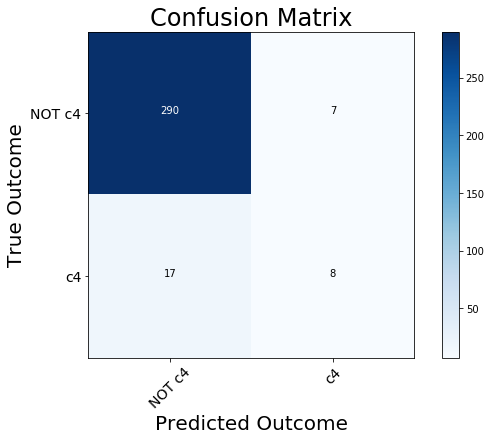

              precision    recall  f1-score   support

      NOT c4       0.94      0.98      0.96       297
          c4       0.53      0.32      0.40        25

    accuracy                           0.93       322
   macro avg       0.74      0.65      0.68       322
weighted avg       0.91      0.93      0.92       322



In [867]:
# Instantiate the model
model4_2 = LogisticRegression(C=1e12, solver='liblinear', random_state=23, max_iter=1000)

# Fit the model
model4_2.fit(X_t, y_t)

# Generate predictions
y_hat_test = model4_2.predict(X_val)
y_hat_test_proba = model4_2.predict_proba(X_val)

pred_cnf_matrix4_2 = confusion_matrix(y_val, y_hat_test, labels = ['NOT c4', 'c4'])
recall, precision = mf.show_cm(pred_cnf_matrix4_2, ['NOT c4', 'c4'])
print (metrics.classification_report(y_val, y_hat_test))

This model did not do well in either precision or recall. We do have an unbalanced dataset so I'll used SMOTE to balance the data for the next model iteration.

#### Class Balancing

In [868]:
# instantiate and fit SMOTE:
smote = SMOTE(random_state = 23)
X_t_bal, y_t_bal = smote.fit_resample(X_t, y_t)
ytb_df = pd.Series(y_t_bal)
ytb_df.value_counts()

c4        890
NOT c4    890
dtype: int64

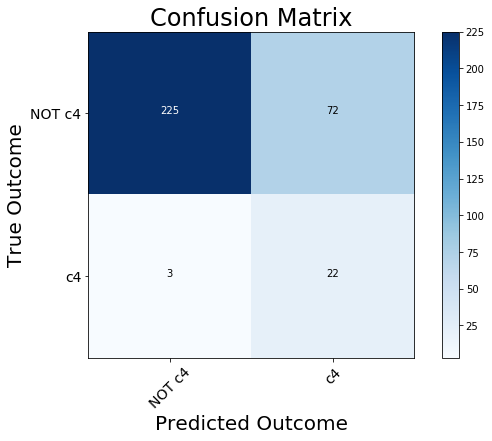

              precision    recall  f1-score   support

      NOT c4       0.99      0.76      0.86       297
          c4       0.23      0.88      0.37        25

    accuracy                           0.77       322
   macro avg       0.61      0.82      0.61       322
weighted avg       0.93      0.77      0.82       322



In [869]:
# Instantiate the model
model4_2_bal = LogisticRegression(C=1e12, solver='liblinear', random_state=23, max_iter=1000)

# Fit the model
model4_2_bal.fit(X_t_bal, y_t_bal)

# Generate predictions
y_hat_test = model4_2_bal.predict(X_val)
y_hat_test_proba = model4_2_bal.predict_proba(X_val)

pred_cnf_matrix4_2_bal = confusion_matrix(y_val, y_hat_test, labels = ['NOT c4', 'c4'])
recall, precision = mf.show_cm(pred_cnf_matrix4_2_bal, ['NOT c4', 'c4'])
print (metrics.classification_report(y_val, y_hat_test))

This model performed much better in identifying c4 players and lowering False Negatives. It did increase the number of False positives quite a bit. Next I'll run a model with regularization of the features. For this I'll need to scale the data first so that features are not unnecessarily penalized.

#### Regularization

In [870]:
ss = StandardScaler()
X_t_scaled = ss.fit_transform(X_t)
X_val_scaled = ss.transform(X_val)

# instantiate and fit SMOTE:
smote = SMOTE(random_state = 23)
X_t_sc_bal, y_t_bal = smote.fit_resample(X_t_scaled, y_t)
ytb_df = pd.Series(y_t_bal)
ytb_df.value_counts()

c4        890
NOT c4    890
dtype: int64

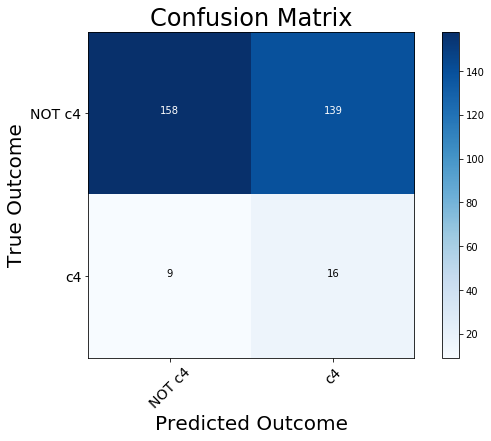

              precision    recall  f1-score   support

      NOT c4       0.95      0.53      0.68       297
          c4       0.10      0.64      0.18        25

    accuracy                           0.54       322
   macro avg       0.52      0.59      0.43       322
weighted avg       0.88      0.54      0.64       322



In [871]:
model4_2reg = LogisticRegressionCV(Cs=1, cv=10, solver='liblinear', random_state=23, max_iter=1000).fit(X_t_sc_bal, y_t_bal)

# Generate predictions
y_hat_test = model4_2reg.predict(X_val_scaled)
y_hat_test_proba = model4_2reg.predict_proba(X_val_scaled)

pred_cnf_matrix4_2_reg = confusion_matrix(y_val, y_hat_test, labels = ['NOT c4', 'c4'])
recall, precision = mf.show_cm(pred_cnf_matrix4_2_reg, ['NOT c4', 'c4'])
print (metrics.classification_report(y_val, y_hat_test))

### Final Tests

Now we'll use the hold out set to run and compare each of our models and choose the one that performs the best

##### MODEL 4.2

              precision    recall  f1-score   support

      NOT c4       0.94      0.99      0.96       395
          c4       0.67      0.29      0.41        34

    accuracy                           0.93       429
   macro avg       0.80      0.64      0.69       429
weighted avg       0.92      0.93      0.92       429



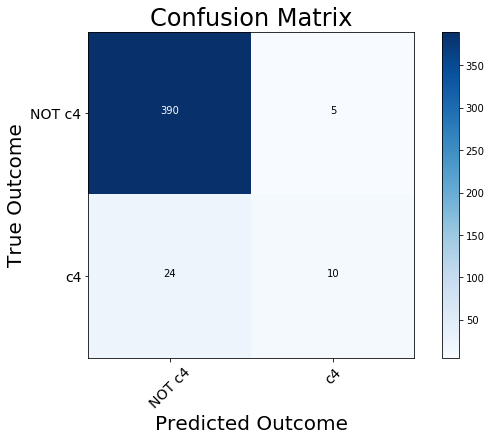

In [904]:
model4_2 = LogisticRegression(C=1e12, solver='liblinear', random_state=23, max_iter=1000)

# Fit the model
model4_2.fit(X_train, y_train)

predicted4_2 = model4_2.predict(X_test)
print (metrics.classification_report(y_test, predicted4_2))

y_hat_test = model4_2.predict(X_test)
pred_cnf_matrix4_2 = confusion_matrix(y_test, y_hat_test, labels = ['NOT c4', 'c4'])
recall, precision = mf.show_cm(pred_cnf_matrix4_2, ['NOT c4', 'c4'])

##### MODEL 4.2 BALANCED

              precision    recall  f1-score   support

      NOT c4       0.97      0.76      0.86       395
          c4       0.22      0.76      0.34        34

    accuracy                           0.76       429
   macro avg       0.60      0.76      0.60       429
weighted avg       0.91      0.76      0.82       429



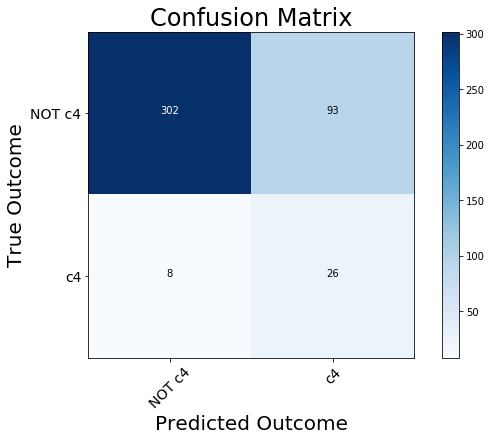

In [905]:
model4_2_bal = LogisticRegression(C=1e12, solver='liblinear', random_state=23, max_iter=1000)

# instantiate and fit SMOTE:
smote = SMOTE(random_state = 23)
X_t_bal, y_t_bal = smote.fit_resample(X_train, y_train)

model4_2_bal.fit(X_t_bal, y_t_bal)
predicted4_2_bal = model4_2_bal.predict(X_test)
print (metrics.classification_report(y_test, predicted4_2_bal))

y_hat_test = model4_2_bal.predict(X_test)
pred_cnf_matrix4_2_bal = confusion_matrix(y_test, y_hat_test, labels = ['NOT c4', 'c4'])
recall, precision = mf.show_cm(pred_cnf_matrix4_2_bal, ['NOT c4', 'c4'])

##### MODEL 4.2 SCALED AND BALANCED WITH REGULARIZATION

In [906]:
ss = StandardScaler()
X_t_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

# instantiate and fit SMOTE:
smote = SMOTE(random_state = 23)
X_t_sc_bal, y_t_bal = smote.fit_resample(X_t_scaled, y_train)

              precision    recall  f1-score   support

      NOT c4       0.99      0.53      0.69       395
          c4       0.14      0.91      0.25        34

    accuracy                           0.56       429
   macro avg       0.57      0.72      0.47       429
weighted avg       0.92      0.56      0.66       429



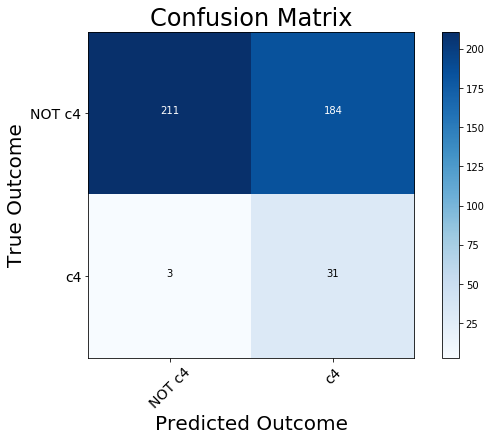

In [907]:
model4_2reg = LogisticRegressionCV(Cs=1, cv=10, solver='liblinear', random_state=23, max_iter=1000).fit(X_t_sc_bal, y_t_bal)

predicted4_2_reg = model4_2reg.predict(X_test_scaled)
print (metrics.classification_report(y_test, predicted4_2_reg))

y_hat_test = model4_2reg.predict(X_test_scaled)
pred_cnf_matrix4_2_reg = confusion_matrix(y_test, y_hat_test, labels = ['NOT c4', 'c4'])
recall, precision = mf.show_cm(pred_cnf_matrix4_2_reg, ['NOT c4', 'c4'])

### Model Comparison

I'll be using ROC_AUC to plot the true positive and false positive rates. The largest area under the curve will tell us which model performed best on the test data. First, I'll need to convert the class targets to binary in order to use the scikit learn modules.

In [908]:
# Changing the target and predictions to binary 

cat_dict = {'NOT c4': 0 , 'c4': 1}
predicted4_2_ = pd.Series(predicted4_2)
predicted4_2_ = pd.Categorical(predicted4_2_.map(cat_dict))
predicted4_2_bal_ = pd.Series(predicted4_2_bal)
predicted4_2_bal_ = pd.Categorical(predicted4_2_bal_.map(cat_dict))
predicted4_2_reg_ = pd.Series(predicted4_2_reg)
predicted4_2_reg_ = pd.Categorical(predicted4_2_reg_.map(cat_dict))

In [909]:
y_test = pd.Categorical(y_test.map(cat_dict))
y_test

[0, 1, 0, 0, 0, ..., 0, 0, 0, 0, 0]
Length: 429
Categories (2, int64): [0, 1]

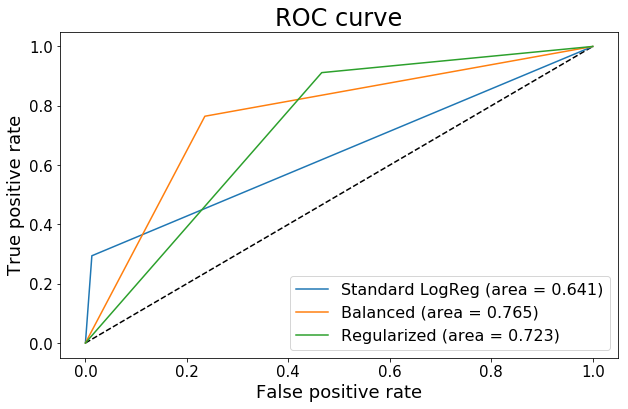

In [910]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr_, tpr_, thresholds_ = roc_curve(y_test, predicted4_2_)
auc_ = auc(fpr_, tpr_)

fpr_sb, tpr_sb, thresholds_sb = roc_curve(y_test, predicted4_2_bal_)
auc_sb = auc(fpr_sb, tpr_sb)

fpr_reg, tpr_reg, thresholds_reg = roc_curve(y_test, predicted4_2_reg_)
auc_reg = auc(fpr_reg, tpr_reg)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_, tpr_, label='Standard LogReg (area = {:.3f})'.format(auc_))
plt.plot(fpr_sb, tpr_sb, label='Balanced (area = {:.3f})'.format(auc_sb))
plt.plot(fpr_reg, tpr_reg, label='Regularized (area = {:.3f})'.format(auc_reg))
plt.xlabel('False positive rate', fontsize=18)
plt.ylabel('True positive rate', fontsize=18)
plt.title('ROC curve', fontsize=24)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)
plt.legend(loc=4, prop={'size': 16})
plt.show()

The takeaway here is that the balanced model performed the best as it has the highest area under the curve of 0.765. We'll use this model to make predictions on current NBA prospects

#### Create a dataset of 2019 and 2020 prospects to run predictions

In [890]:
future_df = pd.read_sql(
    """
    SELECT * FROM full_NCAA
    WHERE (year = 2020 OR year = 2019)
    AND Min_per > 37
    AND GP > 22
    """, conn)
future_df.head()

,player_name,team,conf,GP,Min_per,ORtg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,FTM,FTA,FT_per,twoPM,twoPA,twoP_per,TPM,TPA,TP_per,blk_per,stl_per,ftr,class,ht,porpag,adjoe,pfr,year,pid,ast/tov,pick,drtg,adrtg,dporpag,stops,bpm,obpm,dbpm,gbpm,mp,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,3PAr
0,Josh Warren,Cornell,Ivy,29,64.2,101.1,22.4,57.0,59.81,3.4,15.7,22.6,23.3,55,76,0.724,90,158,0.570,19,50,0.380,2.4,0.9,36.5,Jr,6-8,1.460670,103.8620,3.6,2019,27085,1.142819,NaN,104.504,104.945,2.182750,133.7830,-0.276190,-0.789809,0.513619,-0.177955,25.3871,-0.207793,0.029838,0.7742,3.5806,4.3548,2.5806,0.4516,0.5806,9.7419,0.240385
1,Josh Warren,Cornell,Ivy,25,70.0,99.3,20.1,55.1,58.87,4.1,16.5,23.4,28.2,48,66,0.727,57,99,0.576,16,48,0.333,3.1,1.2,44.9,Sr,6-8,1.415690,99.9015,4.1,2020,27085,1.279412,NaN,108.417,109.639,1.721160,121.3010,-0.816042,-0.538024,-0.278018,-1.960830,28.0370,-1.028020,-0.932807,1.0000,3.7407,4.7407,3.2222,0.5926,0.7778,8.4444,0.326531
2,Dontel Highsmith,Cleveland St.,Horz,29,39.2,113.6,11.8,50.6,56.01,2.2,7.8,9.8,12.4,26,32,0.813,21,41,0.512,14,42,0.333,0.7,1.3,38.6,Sr,6-2,0.600895,98.4936,3.1,2019,31053,2.307344,NaN,114.425,113.061,0.892847,69.5653,-2.819560,-0.537526,-2.282030,-2.378080,15.9355,-1.433770,-0.944310,0.3226,1.1613,1.4839,0.9677,0.3871,0.0968,3.9677,0.506024
3,Emmanuel Toney,Texas A&M Corpus Chris,Slnd,28,72.9,91.2,19.0,44.8,48.04,2.3,11.3,25.3,26.2,38,56,0.679,49,116,0.422,25,77,0.325,0.3,2.2,29.0,Sr,6-2,0.012529,87.5821,2.5,2019,31389,1.571429,NaN,101.888,104.563,2.519780,143.2100,-2.586730,-2.224670,-0.362059,-2.483240,28.9062,-2.403620,-0.079620,0.5625,2.8750,3.4375,3.4375,1.1875,0.0625,7.8125,0.398964
4,Damarion Geter,Longwood,BSth,28,55.9,97.1,13.3,50.0,51.00,5.3,17.2,9.8,21.4,25,47,0.532,41,84,0.488,10,28,0.357,3.7,1.8,42.0,Sr,6-8,-0.284700,84.1424,3.5,2019,31509,1.000000,NaN,102.953,104.237,2.190400,135.6720,-0.684841,-2.905200,2.220360,-2.101820,25.3333,-2.775840,0.674017,1.4667,3.7667,5.2333,1.3000,0.8667,0.7333,5.2667,0.250000


In [883]:
# Clean the dataset

X = dc.clean_future_df(future_df)
X.head()

Min_per   ORtg   usg   eFG  TS_per  ORB_per  DRB_per  \
pid   player_name                                                              
27085 Josh Warren          64.2  101.1  22.4  57.0   59.81      3.4     15.7   
      Josh Warren          70.0   99.3  20.1  55.1   58.87      4.1     16.5   
31053 Dontel Highsmith     39.2  113.6  11.8  50.6   56.01      2.2      7.8   
31389 Emmanuel Toney       72.9   91.2  19.0  44.8   48.04      2.3     11.3   
31509 Damarion Geter       55.9   97.1  13.3  50.0   51.00      5.3     17.2   

                        AST_per  TO_per  FTM  FTA  FT_per  twoPM  twoPA  \
pid   player_name                                                         
27085 Josh Warren          22.6    23.3   55   76   0.724     90    158   
      Josh Warren          23.4    28.2   48   66   0.727     57     99   
31053 Dontel Highsmith      9.8    12.4   26   32   0.813     21     41   
31389 Emmanuel Toney       25.3    26.2   38   56   0.679     49    116   
31509 Damarion Geter        9.8    21.4   25   47   0.532     41     84   

                        twoP_per  TPM  TPA  TP_per  blk_per  stl_per   ftr  \
pid   player_name                                                            
27085 Josh Warren          0.570   19   50   0.380      2.4      0.9  36.5   
      Josh Warren          0.576   16   48   0.333      3.1      1.2  44.9   
31053 Dontel Highsmith     0.512   14   42   0.333      0.7      1.3  38.6   
31389 Emmanuel Toney       0.422   25   77   0.325      0.3      2.2  29.0   
31509 Damarion Geter       0.488   10   28   0.357      3.7      1.8  42.0   

                          porpag     adjoe   ast/tov     drtg    adrtg  \
pid   player_name                                                        
27085 Josh Warren       1.460670  103.8620  1.142819  104.504  104.945   
      Josh Warren       1.415690   99.9015  1.279412  108.417  109.639   
31053 Dontel Highsmith  0.600895   98.4936  2.307344  114.425  113.061   
31389 Emmanuel Toney    0.012529   87.5821  1.571429  101.888  104.563   
31509 Damarion Geter   -0.284700   84.1424  1.000000  102.953  104.237   

                         dporpag     stops       bpm      obpm      dbpm  \
pid   player_name                                                          
27085 Josh Warren       2.182750  133.7830 -0.276190 -0.789809  0.513619   
      Josh Warren       1.721160  121.3010 -0.816042 -0.538024 -0.278018   
31053 Dontel Highsmith  0.892847   69.5653 -2.819560 -0.537526 -2.282030   
31389 Emmanuel Toney    2.519780  143.2100 -2.586730 -2.224670 -0.362059   
31509 Damarion Geter    2.190400  135.6720 -0.684841 -2.905200  2.220360   

                            gbpm       mp     ogbpm     dgbpm    oreb    dreb  \
pid   player_name                                                               
27085 Josh Warren      -0.177955  25.3871 -0.207793  0.029838  0.7742  3.5806   
      Josh Warren      -1.960830  28.0370 -1.028020 -0.932807  1.0000  3.7407   
31053 Dontel Highsmith -2.378080  15.9355 -1.433770 -0.944310  0.3226  1.1613   
31389 Emmanuel Toney   -2.483240  28.9062 -2.403620 -0.079620  0.5625  2.8750   
31509 Damarion Geter   -2.101820  25.3333 -2.775840  0.674017  1.4667  3.7667   

                          treb     ast     stl     blk     pts      3PAr  
pid   player_name                                                         
27085 Josh Warren       4.3548  2.5806  0.4516  0.5806  9.7419  0.240385  
      Josh Warren       4.7407  3.2222  0.5926  0.7778  8.4444  0.326531  
31053 Dontel Highsmith  1.4839  0.9677  0.3871  0.0968  3.9677  0.506024  
31389 Emmanuel Toney    3.4375  3.4375  1.1875  0.0625  7.8125  0.398964  
31509 Damarion Geter    5.2333  1.3000  0.8667  0.7333  5.2667  0.250000

In [884]:
# Run the prediction model and add the columns to the dataset
predicted4_2_bal = model4_2_bal.predict(X)
proba4_2_bal = model4_2_bal.predict_proba(X)

In [885]:
proba4_2_bal = np.round(proba4_2_bal*100, 1)

In [886]:
future_df['prediction'] = predicted4_2_bal
future_df['probability0'] = proba4_2_bal[:, 0]
future_df['probability1'] = proba4_2_bal[:, 1]

In [888]:
final_pred_df = future_df[['year','class','conf','prediction','probability1']].loc[future_df['prediction'] == 'c4'].sort_values(by=['probability1'], ascending=False).reset_index()

Lets look at the final predictions:

In [889]:
final_pred_df

,pid,player_name,year,class,conf,prediction,probability1
0,50577,Steffon Mitchell,2019,So,ACC,c4,100.0
1,66614,Antoine Davis,2020,So,Horz,c4,99.9
2,66146,Braden Norris,2019,Fr,Horz,c4,99.9
3,70665,Chase Claxton,2020,Fr,BSth,c4,99.9
4,50781,Chase Freeman,2020,Jr,NEC,c4,99.8
...,...,...,...,...,...,...,...
183,66608,Kira Lewis Jr.,2020,So,SEC,c4,52.1
184,33674,Trevor John,2019,Sr,CAA,c4,51.4
185,51220,Ian DuBose,2020,Jr,Slnd,c4,51.2
186,46315,Jordan Geist,2019,Sr,SEC,c4,50.3


## IV. Conclusions


The final prediction model had a good recall score but the precision left a lot to be desired. The predictions 
on current prospects skewed more towards the smaller conferences. This could be alleviated by including some 
strength of schedule feature. Additional feature engineering can be done for better results. Also, a different modeling method such as a neural network could perform better. 

## V. Recommendations

Scouts and front office executives can use this this tool for the following purposes:

- View young player's potential career trajectory
- Track player development year over year, adjust strategies 
- Evaluate young players to make decisions on contract commitments
- Better focus scouting on players who would potentially fill needs


## VI. Next Steps

 - Include international player statistics
 - Explore additional clustering and dimensionality reduction methods 
 - Create a web application for clients using Flask or Dash

In [ ]:
conn.close()